# Generate Friction Surface

The friction surface is foundational to raster-based measurement of travel time and accessibility. For most studies of travel time, we recommend using existing friction surfaces, such as the [Global Friction Surface](https://developers.google.com/earth-engine/datasets/catalog/Oxford_MAP_friction_surface_2019) from the Malaria Atlas Project.

However, we often need customized friction surfaces, this could be because of
1. Resolution of the input raster surfaces  
2. Updated baseline datasets (landcover or road network)  
3. Integrate modifications to travel time, such as disruptions  

This notebook will run through a simple process to calcuate a new travel surface using a baseline landcover dataset and a road network.

In [2]:
import sys, os
import rasterio
import overturemaps

import geopandas as gpd

import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.mapMisc as mapMisc

sys.path.append("../../src")
import GOSTnetsraster.market_access as ma
import GOSTnetsraster.conversion_tables as speed_tables

%load_ext autoreload
%autoreload 2

In [5]:
# define input data
base_folder = 'tutorial_data'
iso3 = 'RWA'
# Define your output folder here
output_folder = f"C:/WBG/Work/Projects/HealthAccess/Tutorials/GNR/{iso3}/" #os.path.join(base_folder, iso3)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

aoi_file = os.path.join(output_folder, f'{iso3}_AOI_buffer.geojson')
local_lc_file = os.path.join(output_folder, f'{iso3}_Landcover_projected.tif')
global_friction_file = os.path.join(output_folder, f'{iso3}_global_friction_surface.tif')   
local_road_network = os.path.join(output_folder, "overture_roads.gpkg")
local_friction = os.path.join(output_folder, "custom_friction_surface.tif")

In [7]:
# Download national boundary
if not os.path.exists(aoi_file):    
    global_boundaries = gpd.read_file("https://datacatalogfiles.worldbank.org/ddh-published-v2/0038272/5/DR0095369/World%20Bank%20Official%20Boundaries%20(GeoJSON)/World%20Bank%20Official%20Boundaries%20-%20Admin%200.geojson")
    inA = global_boundaries.loc[global_boundaries['ISO_A3'] == iso3].to_crs(epsg=4326)
    inA.to_file(aoi_file, driver='GeoJSON')

# Download landcover data
if not os.path.exists(local_lc_file):
    in_file = "https://datacatalogfiles.worldbank.org/ddh-published/0066950/DR0095711/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2015-v2.0.7.tif"
    rMisc.clipRaster(rasterio.open(in_file), inA, local_lc_file)    

if not os.path.exists(global_friction_file):
    friction_path = "https://datacatalogfiles.worldbank.org/ddh-published/0066950/DR0095710/2020_motorized_friction_surface.geotiff"
    rMisc.clipRaster(rasterio.open(friction_path), inA, global_friction_file)

# Download Overture road network data
if not os.path.exists(local_road_network):    
    transport = overturemaps.record_batch_reader("segment", list(inA.total_bounds)).read_all()
    transport_df = gpd.GeoDataFrame.from_arrow(transport)
    transport_df.crs = 4326
    # Intersect the roads with the AOI to limit to the area of interest
    transport_df = gpd.sjoin(transport_df, inA.to_crs(transport_df.crs), predicate='intersects', how='inner')
    transport_df.loc[:, ["id", "class", "subtype", "road_surface", "speed_limits", "width_rules", "geometry"]].to_file(local_road_network, driver="GPKG")

# Generate friction surface

In [8]:
roads = gpd.read_file(local_road_network)
roads['speed'] = roads['class'].map(speed_tables.osm_speed_dict).fillna(10)

landcoverR = rasterio.open(local_lc_file)

if roads.crs != landcoverR.crs:
    roads = roads.to_crs(landcoverR.crs)

In [9]:
ma.generate_roads_lc_friction?

Signature:
ma.generate_roads_lc_friction(
    lc_file,
    sel_roads,
    lc_travel_table=None,
    min_lc_val=0.01,
    min_road_speed=0.01,
    speed_col='speed',
    resolution=100,
    out_file='',
)
Docstring:
Combine a landcover dataset and a road network dataset to create
a friction surface. See generate_lc_friction and generate_road_friction for more details

Returns
dictionary of 'meta'[dictionary] and 'friction'[numpy array] - meta is metadata required to write rasterio
    friction is the resulting friction surface used to run in GOSTNets Raster
File:      c:\wbg\work\code\gostnetsraster\src\gostnetsraster\market_access.py
Type:      function

In [10]:
# We need to convert the landcover codes to travel speeds; we have a conversion table for this, but it can be customized
print(speed_tables.esaacci_landcover)

{0: 0.1, 10: 2.5, 11: 4.0, 12: 4.2, 20: 3.24, 30: 2.0, 40: 3.24, 50: 4.0, 60: 3.5, 61: 3.0, 62: 2.5, 70: 3.5, 71: 3.0, 72: 3.24, 80: 3.5, 81: 3.0, 82: 3.24, 90: 3.24, 100: 3.0, 110: 3.0, 120: 4.2, 121: 3.24, 122: 3.24, 130: 4.86, 140: 0.0, 150: 4.2, 151: 4.0, 152: 4.0, 153: 4.0, 160: 2.0, 170: 2.0, 180: 2.0, 190: 5.0, 200: 4.75, 201: 4.5, 202: 4.5, 210: 0.5, 220: 1.0}


In [11]:
meta, friction = ma.generate_roads_lc_friction(landcoverR, roads, lc_travel_table=speed_tables.modis_umd, speed_col='speed', out_file=local_friction)

<module 'matplotlib.pyplot' from 'c:\\WBG\\Anaconda3\\envs\\s2s_ingest\\lib\\site-packages\\matplotlib\\pyplot.py'>

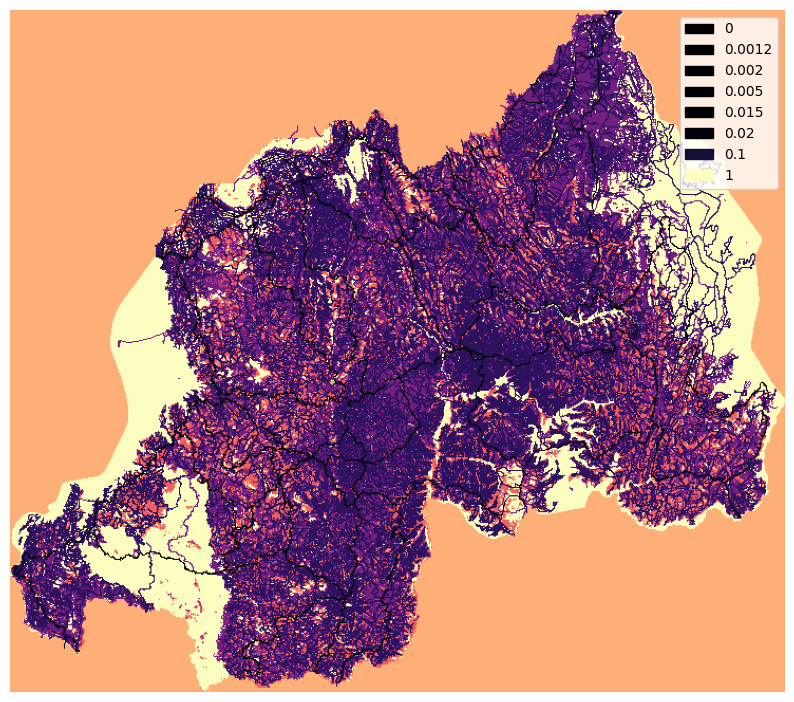

In [12]:
mapMisc.static_map_raster(rasterio.open(local_friction), thresh=[0,0.0012, 0.002, 0.005, 0.015, 0.02, 0.1, 1])

<module 'matplotlib.pyplot' from 'c:\\WBG\\Anaconda3\\envs\\s2s_ingest\\lib\\site-packages\\matplotlib\\pyplot.py'>

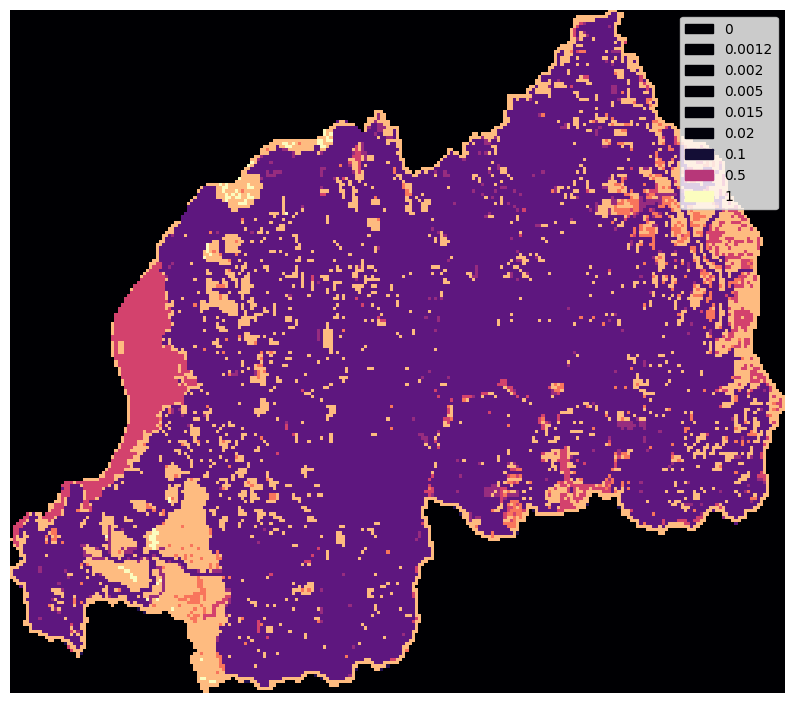

In [15]:
# map the global friction surface for comparison
mapMisc.static_map_raster(rasterio.open(global_friction_file), thresh=[0,0.0012, 0.002, 0.005, 0.015, 0.02, 0.1, 0.5, 1])
